In [1]:
import yfinance as yf
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ticker = "BTC-USD"
start_date = '2025-03-18'
end_date = "2025-03-26"

def get_stock_data(stock_name, start_date, end_date, interval='1d'):
    try:
        df = yf.download(stock_name, start=start_date, end=end_date, interval=interval)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
stock_data = get_stock_data(ticker, start_date, end_date, '1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
row_counts = stock_data.resample("D").size()
row_counts

Datetime
2025-03-18 00:00:00+00:00    1104
2025-03-19 00:00:00+00:00    1112
2025-03-20 00:00:00+00:00    1067
2025-03-21 00:00:00+00:00    1045
2025-03-22 00:00:00+00:00    1034
2025-03-23 00:00:00+00:00    1011
2025-03-24 00:00:00+00:00    1058
2025-03-25 00:00:00+00:00    1044
Freq: D, dtype: int64

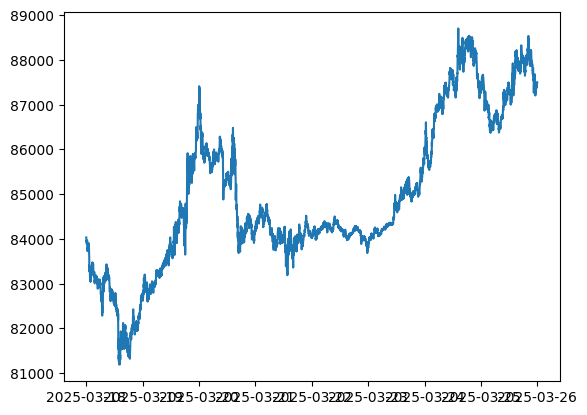

In [5]:
plt.plot(stock_data['Close'])

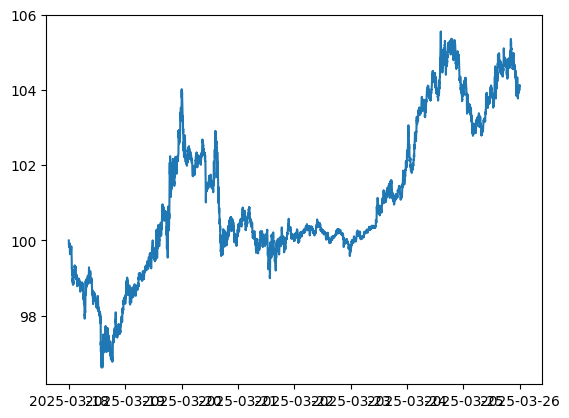

In [6]:
plt.plot(stock_data['Close'] / stock_data['Close'].iloc[0] * 100)

In [7]:
initial_val = stock_data.iloc[0]['Open'][f'{ticker}']
stock_data.columns = ['_'.join(col) for col in stock_data.columns]
stock_pcts = stock_data.pct_change()
stock_pcts_res = stock_pcts.iloc[1:]
stock_pcts_res = stock_pcts_res[f'Open_{ticker}']

In [8]:
means, stds = stock_pcts_res.mean(), stock_pcts_res.std()
stock_pcts_res_norm = (stock_pcts_res - means) / stds

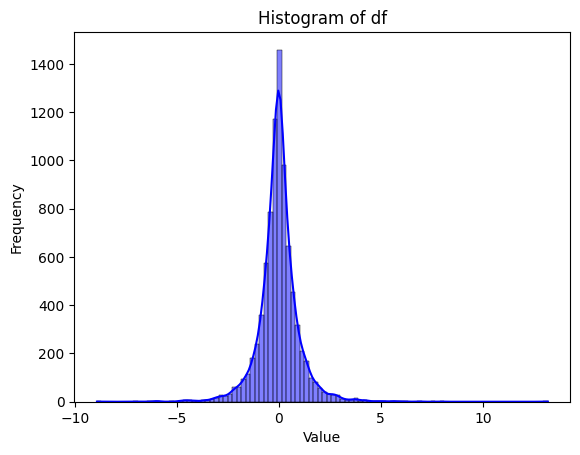

In [9]:
sns.histplot(stock_pcts_res_norm.values, bins=100, kde=True, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of df')
plt.show()

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, seq_len, device='cpu'):
        self.data = data
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        idx = idx % len(self)
        X = self.data[idx: idx + self.seq_len]
        y= self.data[idx + 1: idx + self.seq_len + 1]
        return torch.tensor(X, dtype=torch.float32, device=self.device), torch.tensor(y, dtype=torch.float32, device=self.device)

def train(data, input_size, hidden_size, output_size, num_layers, dropout, breed):
    input_size = data.shape[1]
    hidden_size = HID_DIM
    output_size = data.shape[1]
    num_layers = NUM_LAYERS
    dropout = DROPOUT

    model = BaselineRNN(input_size, hidden_size, output_size, num_layers, dropout, breed).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters())

    best_val_loss = float('inf')

    pbar = tqdm(range(NB_EPOCHS), desc="Epochs", unit="epoch", leave=True)
    for epoch in pbar:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss = running_loss * (1 - COEF) + loss.item() * COEF

        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                test_loss = test_loss * (1 - COEF) + criterion(output, y_batch).item() * COEF

        pbar.set_postfix({'Train Loss': f'{running_loss:.4f}', 'Val Loss': f'{test_loss:.4f}'})
        # Checkpoint if validation loss improves
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), f'best_model_{breed}_{start_date}_{end_date}_{NUM_LAYERS}_{HID_DIM}_{DROPOUT}.pth')

class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, breed='GRU'):
        super(BaselineRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) if breed == 'GRU' else nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.GRU) or isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if "weight_ih" in name:  # Input-hidden weights
                    nn.init.xavier_uniform_(param)
                elif "weight_hh" in name:  # Hidden-hidden weights
                    nn.init.orthogonal_(param)
                elif "bias" in name:  # Bias terms
                    nn.init.zeros_(param)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='linear')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x shape: (seq_len, batch_size, input_size)
        out, h_n = self.rnn(x)  # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc1(out) # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc2(self.act(out))  # out.shape = (batch_size, seq_len, output_size)
        return out

In [11]:
SEQ_LEN = 700
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
PARTITION = 0.5

val_idx = 2000
actual_val_pred_idx = val_idx - SEQ_LEN # Not adding 1 because we cannot check the last prediction
data = stock_pcts_res_norm[:-val_idx].values.reshape(-1, 1)

In [12]:
stock_pcts_res_norm.shape, data.shape

((8474,), (6474, 1))

In [13]:
dataset = MyDataset(data, SEQ_LEN, DEVICE)

len(dataset)

train_size, test_size = int(len(dataset) * PARTITION), len(dataset) - int(len(dataset) * PARTITION)
training_data, testing_data = random_split(dataset, [train_size, test_size])

print('len_training_data', len(training_data))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

NUM_LAYERS = 2
HID_DIM = 32
DROPOUT = 0.5
LR = 1e-4
NB_EPOCHS = 300
COEF = 0.5

len_training_data 2887


In [14]:
def process(df, rdf, model_name, breed):
    model = BaselineRNN(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed).to(DEVICE)
    model.load_state_dict(torch.load(f'{model_name}.pth', weights_only=True))
    model.eval()

    def create_sequences(df):
        X = []
        for i in range(len(df) - SEQ_LEN + 1):
            X.append(torch.tensor((df.iloc[i:i + SEQ_LEN]).values, dtype=torch.float32, device=DEVICE))
        return torch.stack(X, dim=0)

    X = create_sequences(df)
    norm_predictions = model(X.clone().detach())[:-1]  # We cannot compare the last prediction
    # predictions, seq_len, features
    with torch.no_grad():
        torch_stds = torch.tensor(np.array(stds).reshape(1, -1), device=DEVICE)
        torch_means = torch.tensor(np.array(means).reshape(1, -1), device=DEVICE)
        predictions = norm_predictions[:, -1, :]  * torch_stds + torch_means 
        
        col = np.array(predictions.cpu())
    col_name = f'Pred_{model_name}'
    
    shift = rdf.shape[0] - col.shape[0]
    
    if shift > 0:
        new_col = np.concatenate([np.full(shift, np.nan), col.reshape(-1)]) # Starting from the fitting index
    else:
        new_col = col
        
    rdf[col_name] = new_col

def analyze_movement_probabilities(df, stock_real_movement, interval_size=10):
    """Analyze discrete probabilities of stock movements"""
    colors = sns.color_palette("husl", 20)
    
    plt.figure(figsize=(16, 4 * ((len(df.columns) - 1 + 1) // 2)), constrained_layout=True)
    
    for idx, col in enumerate(df.columns[1:], 1):
        pl = np.sign(df[col])[1:] * stock_real_movement.diff()[1:]
        sums = [pl.iloc[i:i + interval_size].sum() for i in range(0, len(pl), interval_size)]
        
        plt.subplot((len(df.columns) - 1 + 1) // 2, 2, idx)
        
        counts, bins = np.histogram(sums, bins=20)
        probabilities = counts / sum(counts)
        
        for i in range(len(bins) - 1):
            plt.bar(
                bins[i], probabilities[i], width=np.diff(bins)[i], 
                color=colors[i % len(colors)], edgecolor='black', alpha=0.75
            )
            plt.text(
                bins[i], probabilities[i] + 0.005, f"{probabilities[i]:.2f}", 
                ha='center', fontsize=8, fontweight='bold'
            )
        
        plt.xlabel("Sum of Stock Movements", fontsize=10)
        plt.ylabel("Discrete Probability", fontsize=10)
        plt.title(f"Movement Probability: {col}", fontsize=12, fontweight='bold')
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.ylim(0, max(probabilities) + 0.05)
    
    plt.show()

def explain(df, stock_real_movement, interval=None):
    """Comprehensive stock prediction analysis"""
    if interval:
        df = df.iloc[interval]
        stock_real_movement = stock_real_movement.iloc[interval]
    
    timeline = df.index
    
    # 1. Trend Accuracy
    print("Trend Accuracy:")
    for col in df.columns[1:]:
        trend_accuracy = (np.sign(df.iloc[:, 0]) == np.sign(df[col])).sum() / df.shape[0]
        print(f"{col}: {trend_accuracy:.2%}")
    
    # 2. Trading Strategy Simulation
    print("\nTrading Strategy Performance:")
    for col in df.columns[1:]:
        trade_performance = (np.sign(df[col])[1:] * stock_real_movement.diff()[1:]).sum()
        print(f"{col}: {trade_performance:.4f}")
    
    # 3. Cumulative Profit/Loss Visualization
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    for col in df.columns[1:]:
        pl = (np.sign(df[col])[1:] * stock_real_movement.diff()[1:]).cumsum()
        plt.plot(timeline[1:], pl, label=col, linewidth=2)
    plt.title('Cumulative Trading Performance', fontsize=12, fontweight='bold')
    plt.xlabel('Timeline', fontsize=10)
    plt.ylabel('Cumulative P/L', fontsize=10)
    plt.legend(title='Models', loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 4. Periodic Profit/Loss
    plt.subplot(122)
    for col in df.columns[1:]:
        pl = (np.sign(df[col])[1:] * stock_real_movement.diff()[1:])
        plt.plot(timeline[1:], pl, label=col, linewidth=2)
    plt.title('Periodic Trading Performance', fontsize=12, fontweight='bold')
    plt.xlabel('Timeline', fontsize=10)
    plt.ylabel('Periodic P/L', fontsize=10)
    plt.legend(title='Models', loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    # 5. Values distribution
    plt.figure(figsize=(16, 8))  # Increased figure height
    df_melt = df.melt(var_name='Column', value_name='Value')
    
    unique_columns = df_melt['Column'].unique()
    color_palette = sns.color_palette('Set2', n_colors=len(unique_columns))
    color_dict = dict(zip(unique_columns, color_palette))
    
    sns.histplot(data=df_melt, x='Value', hue='Column', 
                 bins=50,  
                 kde=False, 
                 edgecolor='black', 
                 palette=color_dict,
                 alpha=0.6,
                 common_norm=False)
    
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Predictions', fontsize=14, fontweight='bold')
    plt.legend(title='Columns', loc='best', labels=unique_columns)  # Added title and labels
    plt.tight_layout()
    plt.show()

In [15]:
model_names = [f'best_model_GRU_{start_date}_{end_date}_{NUM_LAYERS}_{HID_DIM}_{DROPOUT}',
               f'best_model_LSTM_{start_date}_{end_date}_{NUM_LAYERS}_{HID_DIM}_{DROPOUT}']
breeds = ['GRU', 'LSTM']

In [16]:
# Training
for breed in breeds:
    train(data, data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed)

Epochs: 100%|█████████████████████████████████| 300/300 [05:15<00:00,  1.05s/epoch, Train Loss=0.3789, Val Loss=0.3066]


In [17]:
df = stock_pcts_res_norm.iloc[-val_idx:].copy().to_frame()
rdf = stock_pcts_res.iloc[-val_idx:].copy().to_frame()[-actual_val_pred_idx:]
stock_datam = stock_data.iloc[-actual_val_pred_idx:, 0]

In [18]:
def everything(df, rdf, stock_data, model_names, breeds, interval_size=10, interval=None):
    for model_name, breed in zip(model_names,breeds):
        process(df, rdf, model_name, breed)
    stock_real_movement = stock_data * (1 + rdf.iloc[:, 0]).cumprod()
    explain(rdf, stock_real_movement, interval)
    analyze_movement_probabilities(rdf, stock_real_movement, interval_size)

Trend Accuracy:
Pred_best_model_GRU_2025-03-18_2025-03-26_2_32_0.5: 51.00%
Pred_best_model_LSTM_2025-03-18_2025-03-26_2_32_0.5: 48.77%

Trading Strategy Performance:
Pred_best_model_GRU_2025-03-18_2025-03-26_2_32_0.5: 1127.7219
Pred_best_model_LSTM_2025-03-18_2025-03-26_2_32_0.5: -5735.2351


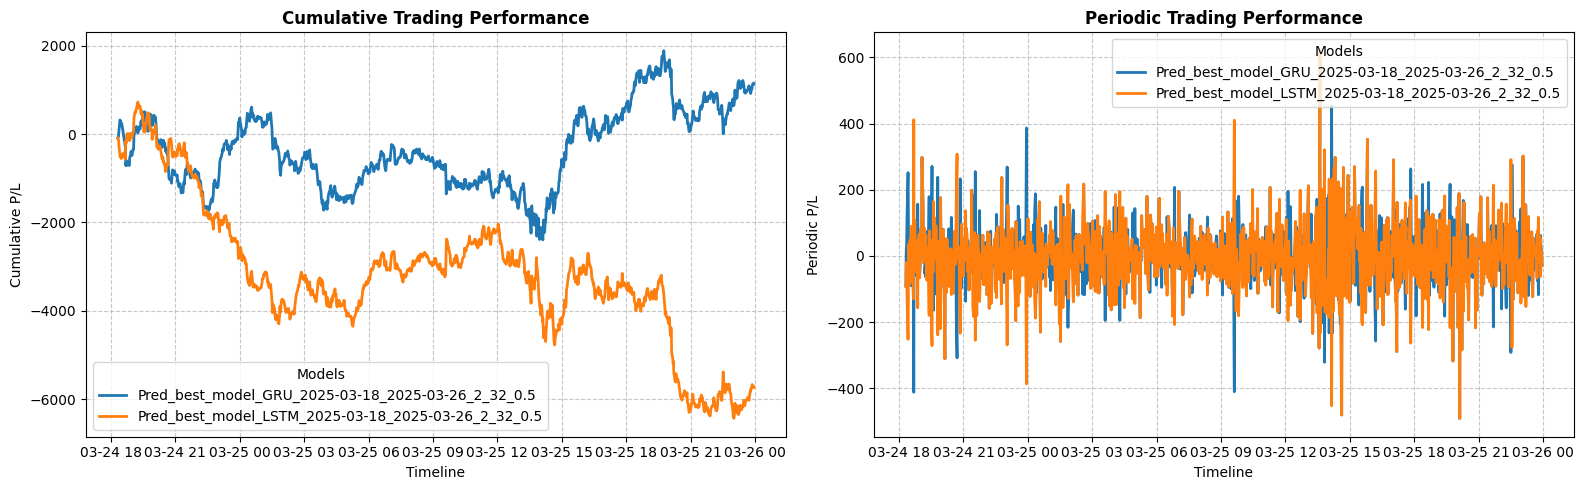

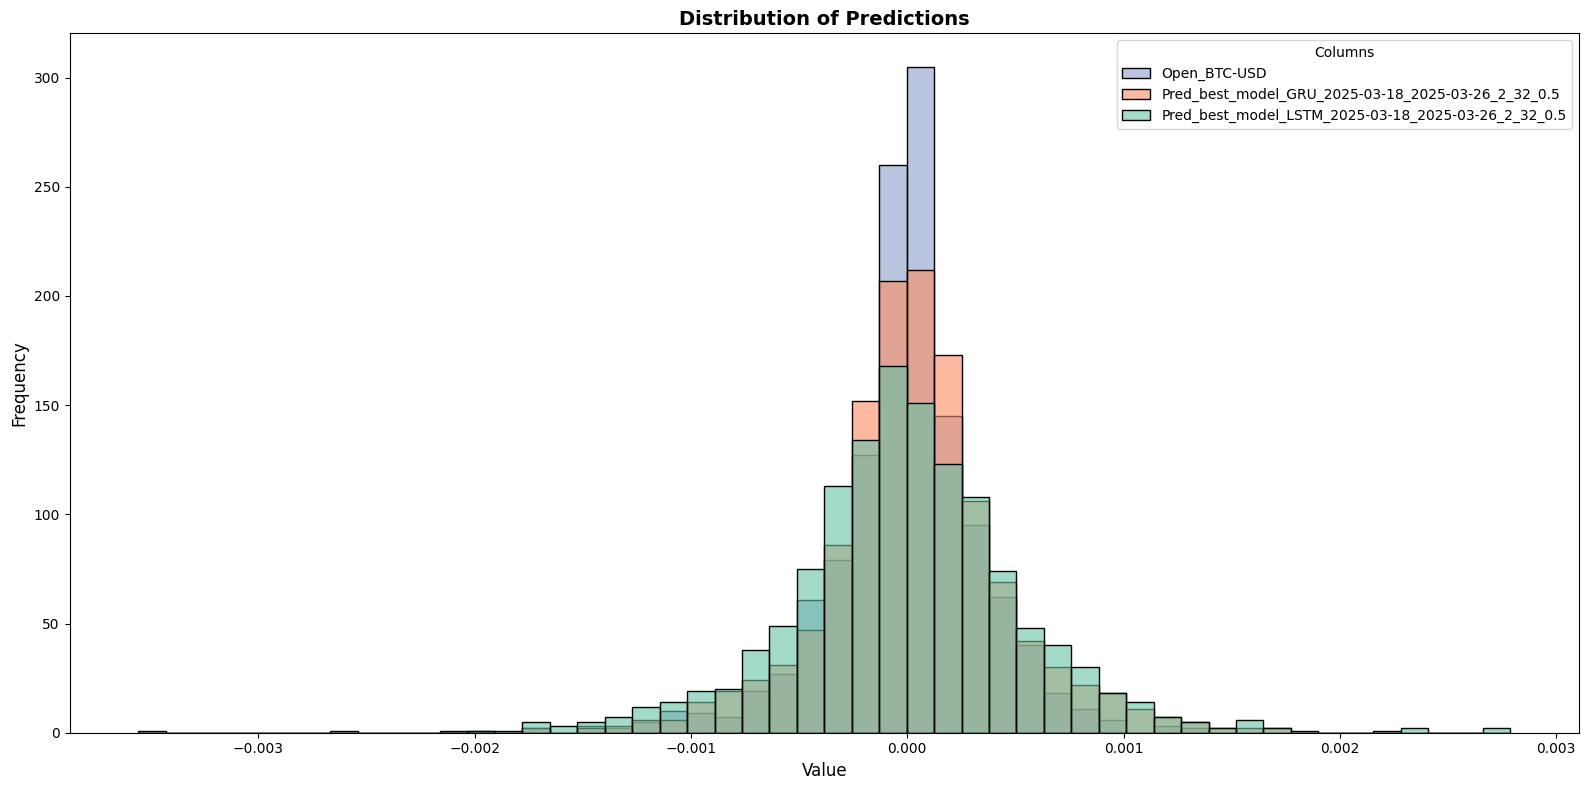

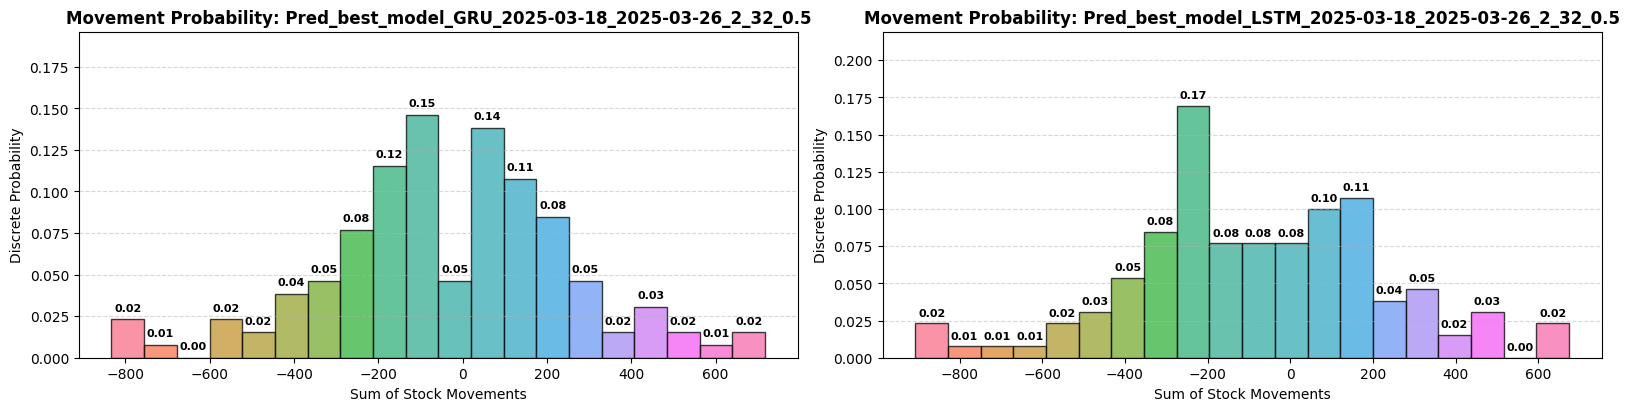

In [19]:
everything(df, rdf, stock_datam, model_names, breeds)